# Pyro 101 - *A quick introduction to Pyro*

This notebooks shows the core principles of [Pyro](https://pyro.ai/)
Which is a convenient framework for variational inference. 

In this notebook, we will

1. simulate a very simple dataset, using a linear model
2. Introduce Pyro "ingredients" required to define and fit a model to the data.
3. Use stochastic variational inference to fit our model
4. observe where how our variational model is mis-specified, and find a way to fix it
5. (optional) build your own model and data, and use Pyro to fit model to data yourself.


Without going too much in details, you can see variational inference as a method for recovering a family of possible models that can explain your data, and for each member of the model family, we get an approximation of how good this element is.
This approximation is given by the so-called variational distribution, which is called a **guide** in Pyro (the model is simply called **model**).

More specifically, a Pyro model specifies a **prior distribution** of the model's parameters: this is an way of encoding which parameter values are more likely than others, based on your knowledge before you see the data. 

The other essential part of a Pyro model is the **data distribution**: this specifies the likelihood of a data point, given a specific set of parameters.

**Let's look at a very simple example to see what this means in practice.**

First, we have to import some python modules.



In [73]:
# first import pyro

import pyro
import torch

# then import pyro.distributions
import pyro.distributions as dist

# import the SVI class for stochastic variational inference
from pyro.infer import SVI, Trace_ELBO

# import the Adam optimizer
from pyro.optim import Adam

# we also need some plotting tools and other stuff
import matplotlib.pyplot as plt
import numpy as np
import tqdm

## 1. Create a dataset

Let's generate some simple data

We'll simulate pairs $(x,y)$ using a linear model. We'll usume that the measurement error $\sigma$ is known and fix it to 0.5. Notice that the $x$ values are not centered at zero. This will be important later. 

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y'), Text(0.5, 1.0, 'simulated data')]

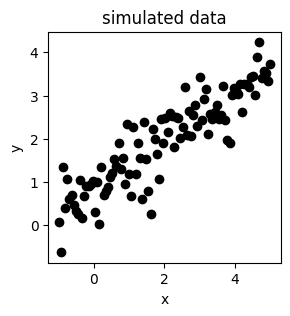

In [74]:
sigma = 0.5 # assumed known
xs = torch.linspace(-1, 5, 100)
# ground truth slope and intercept are 0.5 and 1
ys = 0.5 * xs + 1 + torch.randn(xs.size()) * sigma
# stack the data into pairs. The first dimension is the "batch dimension"
# the second dimension is the "feature dimension"
data = torch.stack([xs, ys], dim=-1)

# plot the data
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.scatter(xs.numpy(), ys.numpy(), color='k')
ax.set(xlabel='x', ylabel='y', title="simulated data")


## 2. Pyro ingredients

Next, we'll define a linear model in Pyro.

A Pyro model is a python function that usually takes data as input, and contains a number of so-called Pyro *primitives*. These include 

- `pyro.sample`: for sampling parameters from a (prior) distribution. You'll have to give the name (a string) of the parameter, and the (prior) distribution. `pyro.sample` is also used to "sample" data, or to compute the likelihood of some observed value.
- `pyro.plate`: this is a way to deal with multiple observations and signals that individual observations are conditionally independent.

In our model, we will first sample a slope and intercept from some prior distribution (we choose a standard normal). Then, we will create the expected value of $y$ (called `yhat` below): $$\hat{y} = \text{slope} \times x + \text{intercept}$$ 
Finally, we use again the `pyro.sample` primitive to "sample" the data, but this time we also include the observed value $y$: this will be used to compute the likelihood of $y$ given $\hat{y}$. 

In [75]:
def model(data):
    # prior distributions for slope and intercept
    slope = pyro.sample("slope", dist.Normal(0., 1.))
    intercept = pyro.sample("intercept", dist.Normal(0., 1.))
    
    # likelihood: how the data is generated given slope and intercept
    with pyro.plate("data", data.size(0)):
        x = data[:, 0]
        y = data[:, 1]
        yhat = slope * x + intercept
        pyro.sample("obs", dist.Normal(yhat, sigma), obs=y)

The next step is to define the `guide` (i.e. variational distribution).
In this case, we will try to estimate a typical slope value `slope_loc` (loc refers to "location"), and the uncertainty in our estimate `slope_scale`. The variational distribution for the `slope` parameter is a Normal distribution with mean `slope_loc` and standard deviation `slope_scale`. One we have estimates for our **variational parameters** `slope_loc` and `slope_scape`, we have a way of describing which parameter values are more or less likely in light of the obseved data (and prior knowledge).

We do the same for the `intercept` parameter.

A `guide` is again a regular python function, and it has to take exactly the same parameters as the `model` function (even if they are not used, as in our case). 

In the `guide` below, we introduce a new primitive: the `pyro.param` function.
This makes sure that the required parameters get defined on the right domain (e.g. scales are positive), and we have to specify an initial guess.

Once we have defined our variational parameters, we can sample model parameters using the usual `pyro.sample` primitive. As before, this takes a name and a distribution. The names **HAVE** to correspond to the parameters specified in the model, and the distribution is now not the prior, but the variational distributrion.

In [76]:
def guide(data):
    # variational parameters for slope
    slope_loc = pyro.param("slope_loc", torch.tensor(0.0))
    slope_scale = pyro.param("slope_scale", torch.tensor(1.0), constraint=dist.constraints.positive)
    
    # variational parameters for intercept
    intercept_loc = pyro.param("intercept_loc", torch.tensor(0.0))
    intercept_scale = pyro.param("intercept_scale", torch.tensor(1.0), constraint=dist.constraints.positive)
    
    # define the variational distributions
    pyro.sample("slope", dist.Normal(slope_loc, slope_scale))
    pyro.sample("intercept", dist.Normal(intercept_loc, intercept_scale))

That's it! Now we'll fit the model to our simulated data using SVI.

## 3. Fitting the model with SVI

SVI means `stochastic variational inference`, which means that we're using a stochastic algorithm to find an "optimal" variational distribution. "optimal" refers to optimization of the so-called **evidence lower bound (ELBO)**. In Bayesian stats, the **evidence** of a model is a measure of how well the model is supported by the data. In variational inference, we can estimate a lower bound of this evidence (hence the name), which depends on the variational parameters. By iteratively maximizing the ELBO, we get a better supported model. Pyro is built on top of **pyrorch** which uses automatic differentiation for optimization. However, in SVI, one hase to sample random parameter values to approximate the ELBO (and the gradient of the ELBO). This explains the S (Stochastic) in SVI. 




  0%|          | 0/2000 [00:00<?, ?it/s]

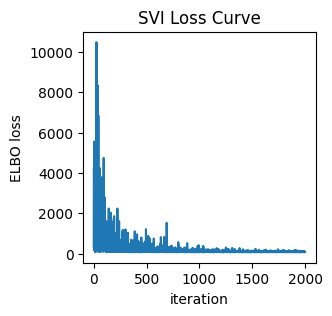

In [77]:
# if we run this cell multiple times, we need to clear the "parameter store" 
# i.e. reset all parameters to their initial values.

pyro.clear_param_store()

# setup the SVI object
svi = SVI(
    model, # the model function defined above
    guide, # the guide function defined above
    Adam({"lr": 0.01}), # the optimizer (here we use Adam)
    loss=Trace_ELBO() # the loss function (here we use the ELBO)
)

# run the SVI for some number of iterations
num_iterations = 2000
losses = [] # to store the loss at each iteration and check convergence

for step in (pbar := tqdm.notebook.trange(num_iterations)):
    loss = svi.step(data) # perform a SVI step and get the loss
    # this is where the optimization happens
    losses.append(loss)
    if step % 100 == 0:
        pbar.set_description(f"Step {step} : loss = {loss:0.3f}")

# plot the loss curve

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(losses)
ax.set(xlabel='iteration', ylabel='ELBO loss', title='SVI Loss Curve')

pass

We see that the loss (-ELBO) decreases on average, but we also see a lot of stochastic behavior. This relates to a problem that we'll solve below.

Let's see what we estimated and how it fits the data.

[Text(0.5, 0, 'x'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Learned Linear Regression with Uncertainty')]

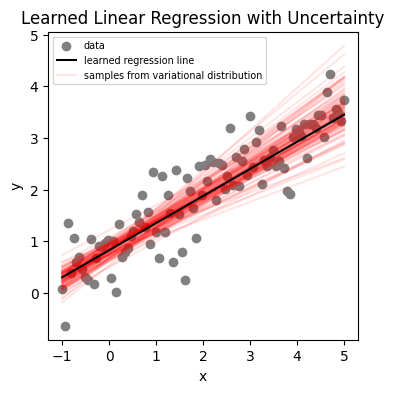

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# scatter the original data
ax.scatter(xs.numpy(), ys.numpy(), color='gray', label='data', zorder=0)

# get the learned parameters
param_store = pyro.get_param_store()

slope_est = param_store['slope_loc'].item()
intercept_est = param_store['intercept_loc'].item()

# plot the learned regression line
x_line = np.array([-1, 5])
y_line = slope_est * x_line + intercept_est
ax.plot(x_line, y_line, color='k', label='learned regression line', zorder=2)

# sample from the learned variational distributions to show uncertainty
slope_scale = param_store['slope_scale'].item()
intercept_scale = param_store['intercept_scale'].item()
legend = 'samples from variational distribution'
for _ in range(100):
    # here we "manually" sample from the variational distributions
    # to plot possible regression lines
    # below we will see a more convenient way to do this...
    slope_sample = np.random.normal(slope_est, slope_scale)
    intercept_sample = np.random.normal(intercept_est, intercept_scale)
    y_sample_line = slope_sample * x_line + intercept_sample
    ax.plot(x_line, y_sample_line, color='r', alpha=0.1, label=legend, zorder=1)
    legend = None  # only label the first line

ax.legend(fontsize='x-small')
ax.set(xlabel='x', ylabel='y', title='Learned Linear Regression with Uncertainty')

We see that the model captures the linear trend very well, but also that the uncertainty in our estimates is quite large. Next, we'll reconsider some choices to see if we can fix this.

## 4. Improving the `guide`

In our definition of the guide, we made the assumption that the slope and intercept are independent. However, as the x variable is not centered at zero, we can trade off a higher intercept for a lower slope. To include this in our guide, we would have to introduce the joint distribution of the slope and intercept. This can be a bit tedious. Fortunately, Pyro has a number of "auto guides". In this case we'll use the `AutoMultivariateNormal` which does exacly what we need:

  0%|          | 0/2000 [00:00<?, ?it/s]

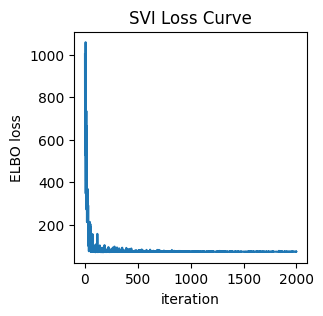

In [79]:
pyro.clear_param_store()

from pyro.infer.autoguide import AutoMultivariateNormal

auto_guide = AutoMultivariateNormal(model)

svi_auto = SVI(model, auto_guide, Adam({"lr": 0.01}), loss=Trace_ELBO())
num_iterations = 2000
losses_auto = []
for step in (pbar := tqdm.notebook.trange(num_iterations)):
    loss = svi_auto.step(data)
    losses_auto.append(loss)
    if step % 100 == 0:
        pbar.set_description(f"Step {step} : loss = {loss:0.3f}")

# plot the loss curve

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(losses_auto)
ax.set(xlabel='iteration', ylabel='ELBO loss', title='SVI Loss Curve')

pass
   

We quite rapidly converge to an optimum, and the stochasticity is much more constrained than in the previous fit.

Again, let's look at the results

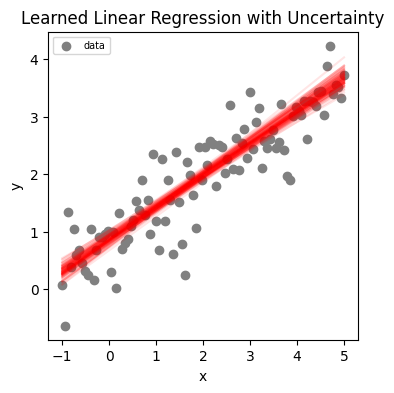

In [80]:
# again plot the regression results

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# scatter the original data
ax.scatter(xs.numpy(), ys.numpy(), color='gray', label='data', zorder=0)

# use Predictive to get samples from the posterior predictive distribution

from pyro.infer import Predictive
predictive = Predictive(model, guide=auto_guide, num_samples=100)
samples = predictive(data=data)
slope_samples = samples['slope'].numpy()
intercept_samples = samples['intercept'].numpy()

# plot the learned regression lines from the samples
x_line = np.array([-1, 5])
for slope_sample, intercept_sample in zip(slope_samples, intercept_samples):
    y_line = slope_sample * x_line + intercept_sample
    ax.plot(x_line, y_line, color='r', alpha=0.1, zorder=1)

ax.legend(fontsize='x-small')
ax.set(xlabel='x', ylabel='y', title='Learned Linear Regression with Uncertainty')

pass

Compared to the model with "manual" guide, the uncertainty in our estimate is much smaller!

## 5. Exercise:

1. Come up with a simple model and generate some data. For instance, simulate data with a logistic growth model, or using a $\sin$ function.
2. Write a Pyro model function for your model
3. Write your own guide or use an appropriate autoguide
4. Fit the model with SVI and inspect the results.
5. Diagnose any issues and find ways to improve your model/guide.

In [81]:
# your code here...